In [1]:
import numpy as np
import fipy as fp
import scipy.constants as sc

import time

import matplotlib.pyplot as plt
#plt.rcParams["animation.html"] = "jshtml"
#from matplotlib.animation import FuncAnimation
#from IPython.display import HTML

def update_progress(process,progress):
    import sys
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\r"+process+": [{0}] {1:.0f}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()
    
print(fp.DefaultSolver)

<class 'fipy.solvers.petsc.linearGMRESSolver.LinearGMRESSolver'>


In [2]:
Te = 4000 #eV
n0 = 1e8 #line integrated density
n_hot = 5e19 #ambient density [m^-3]
M = 2. * sc.m_p #atomic mass

LL = 12
#Braginskii Eq. 2.5e
tee = 12. * np.pi**1.5 /2**0.5 * sc.m_e**0.5 * sc.epsilon_0**2 * (sc.e * Te)**1.5 / (sc.e**4 * n_hot * LL)
SQ  = 3. * n0 * Te * 1.6e-19 / tee 
tau = 1./ (3. * n0) * SQ # Dnestrovskiy Eq. 65

#Analytical solution
n_ana   = lambda x,t: np.sqrt(3.*M/(8.*t**3*np.pi*tau))*np.exp(-3.*M*x**2/(8.*t**3*tau))
#T = tau * t
#v  = 1.5 * x / t

Our mesh will span $[-L_x/2;L_x/2]$

In [3]:
Lx = 400.; dt = 0.5e-6; steps = 500

In [4]:
#base = 30; N =200
#nonUniform_x = Lx/(base-1.)*(np.logspace(0.,1.,N+1,base=base,endpoint=True)-1.)
#mesh  = fp.Grid1D(dx=np.diff(nonUniform_x))

mesh = fp.Grid1D(nx=1000, Lx=Lx) - 0 * Lx/2.; 
x = mesh.x

''Shallow water'' equations for expanding plasma take the form
\begin{equation}
\frac{\partial n}{\partial t} + \frac{1}{\partial x} (nv) = 0,
\end{equation}
\begin{equation}
\frac{\partial v}{\partial t} + v\frac{\partial v}{\partial x} = - \frac{T(t)}{nM}\frac{\partial n}{\partial x}
\end{equation}

In [5]:
n = fp.CellVariable(mesh=mesh, hasOld = True)
v = fp.CellVariable(mesh=mesh, hasOld = True)
v_face = fp.FaceVariable(mesh=mesh, rank=0, value=0.)

T = fp.Variable(value = 0.)

In [6]:
#cont_eq = (fp.TransientTerm(var=n) + fp.ConvectionTerm(coeff=v.faceValue*[[1.0]], var=n) == 0)
#moti_eq = (fp.TransientTerm(var=v) + fp.ConvectionTerm(coeff=v.faceValue*[[0.5]], var=v) + T / M * n.grad[0]/n == fp.DiffusionTerm(coeff=1.e6,var=v)) # T * (fp.numerix.log(n.faceValue)).divergence #

#cont_eq = (fp.TransientTerm(var=n) + fp.ConvectionTerm(coeff=v_face*[[1.0]], var=n) == 0)
#moti_eq = (fp.TransientTerm(var=v) + fp.ConvectionTerm(coeff=v_face*[[0.5]], var=v) + T / M * n.grad[0]/n == fp.DiffusionTerm(coeff=1.e6,var=v)) # T * (fp.numerix.log(n.faceValue)).divergence #

cont_eq = (fp.TransientTerm(var=n) + fp.ConvectionTerm(coeff=v_face*[[1.]], var=n) == 0)
moti_eq = (fp.TransientTerm(var=v) + fp.ConvectionTerm(coeff=v_face*[[1.]], var=v) - \
                    fp.ImplicitSourceTerm(coeff=v_face.divergence, var=v) + T / M * n.grad[0]/n == fp.DiffusionTerm(coeff=1.e6,var=v))

eqn = cont_eq & moti_eq

Rough boundary conditions for $v$ and $n$ on the right.

In [7]:
n.faceGrad.constrain(0.  , where=mesh.facesLeft)  #correct
n.faceGrad.constrain(0.  , where=mesh.facesRight) #arbitrary 
v.constrain(0.           , where=mesh.facesLeft)  #correct
v.faceGrad.constrain(0.  , where=mesh.facesRight) #arbitrary 

#Initial conditions == analytical around finite density
t = 10.e-6
T.setValue(tau*t)
v.setValue(1.5*x/t, where= x < 10.)
v.setValue(0., where= x >= 10.)
n.setValue(n0*n_ana(x,t)+1e-15*n0/300)

Check convergence

In [8]:
n.updateOld()
v.updateOld()

res = 1e100
for i in range(100):
    v_face[:] = v.arithmeticFaceValue
    v_face[..., mesh.facesLeft.value] = 0.
    res = eqn.sweep(dt=dt)
    print(res)
t += dt

6188891535743.795
2.945613471800911e+18
4.479535579484638e+23
4.493617561019341e+22
1.0926114997987734e+22
2.6101651991604704e+21
6.3433172575606e+20
1.557947349073216e+20
3.822709259039078e+19
9.3989248208487e+18
2.305900214123529e+18
5.612070827616478e+17
1.3471000795458498e+17
3.1673003724301332e+16
7404961891972778.0
1804493661598282.2
454029500619669.8
115181525629723.89
29244019658586.12
6891873137491.468
1216826843027.6611
487031370988.6832
450870278727.06464
342068069441.8376
114776606072.20105
173491166168.29446
68185862514.93431
96390732769.00186
32970059233.913746
59075440802.921196
18544272537.058613
33974079007.941
10975715093.802519
20339508984.982826
6326305756.408315
11714800818.758322
3756028003.838876
6864207513.677132
2197163294.2535133
3971136310.2591634
1299263551.323517
2311657162.4683156
764252159.0824708
1340123474.1037154
451159815.2799031
778529258.4939299
265826209.45168963
451643786.9495594
156795516.97767588
262188442.43688115
92413852.91909589
152128439.18

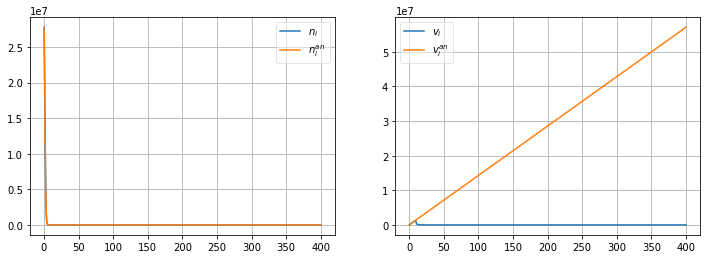

In [9]:
fig = plt.figure(figsize=(12,4))
ax1 =  fig.add_subplot(121)
ax2 =  fig.add_subplot(122)

x_plot = x.value
p_n,      = ax1.plot(x_plot, n.value, '-', label = '$n_i$')
p_v,      = ax2.plot(x_plot, v.value, '-',label = '$v_i$')
a_n,      = ax1.plot(x_plot, n0*n_ana(x.value,t), '-', label = '$n_i^{an}$')
a_v,      = ax2.plot(x_plot, 1.5*x.value/t, '-',label = '$v_i^{an}$')

ax1.grid()
ax2.grid()
ax1.legend(framealpha=0.5)
ax2.legend(framealpha=0.5)

In [10]:
t_list = []; n_list = []; u_list = []; n_sweeps = []

def update(i):
    update_progress('Progress',1.*i/steps)
    global t,tau,T
    n.updateOld()
    v.updateOld()
    T.setValue(t*tau)
    res = 1e100
    isweep = 0
    while res > 1.:
        isweep+=1
        v_face[:] = v.arithmeticFaceValue
        v_face[..., mesh.facesLeft.value] = 0.
        res = eqn.sweep(dt=dt)    
        if isweep > 100:
            print(i,'No converge',res)
            break
    n_sweeps.append(isweep)
    #print(isweep, res)
    t_list.append(t)
    n_list.append(n.value.copy())
    u_list.append(v.value.copy())
    t = t + dt

In [11]:
start = time.time()
for i in range(steps):
    update(i)
print('Computation walltime ', time.time()-start)

Progress: [####################################################################################################] 100% Computation walltime  320.7130470275879


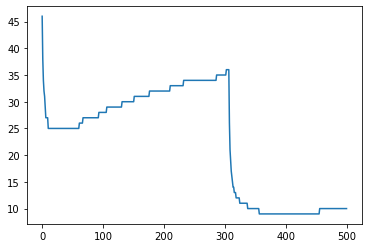

In [12]:
plt.plot(n_sweeps)

In [13]:
#import pickle
#pickle.dump((t_list,n_list,u_list),open( "save.p", "wb" ))

In [14]:
#import pickle
#t_list,n_list,u_list = pickle.load(open( "save.p", "rb" ))

In [15]:
def plot_func(i):   
    p_n.set_ydata(n_list[i])
    p_v.set_ydata(u_list[i])
    a_n.set_ydata(n0*n_ana(x.value,t_list[i]))
    a_v.set_ydata(1.5*x.value/t_list[i])
    ax1.set_ylim((0,max(n_list[i])*1.2))
    ax2.set_ylim((0,max(1.5*x.value/t_list[i])*1.2))

In [18]:
#animation2 = FuncAnimation(fig, plot_func, frames=steps, repeat=False)
#animation2

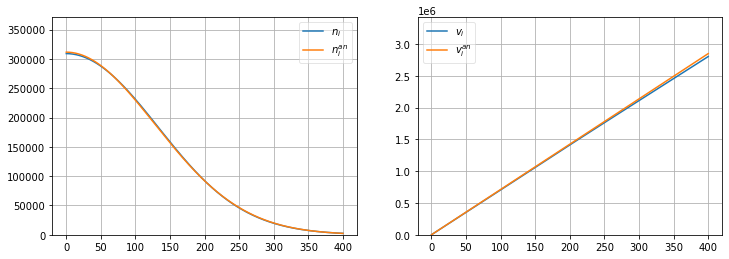

In [18]:
plot_func(steps-100)
fig